In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
import pyspark.sql.functions as f
import os

os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

config = {
    ('spark.dynamicAllocation.enabled', 'false'),
    ('spark.executor.instances', '2'),
    ('spark.executor.cores', '6'),
    ('spark.executor.memory', '8g'),
    ('spark.driver.memory', '10g'),
    ('spark.eventLog.enabled', 'false'),
    ('spark.sql.repl.eagerEval', 'enabled'),
    ('spark.sql.execution.arrow.pyspark.enabled', 'true'),
    ('spark.executor.heartbeatInterval', '60s'),
    # ('spark.memory.fraction', '0.8'),
    # ('spark.memory.storageFraction', '0.3')
    # ("spark.executor.extraJavaOptions", "-Xms4g -XX:+UseG1GC"),
    # ("spark.driver.extraJavaOptions", "-Xms2g -XX:+UseG1GC"),
    ("spark.sql.shuffle.partitions", "50"),
    ("spark.driver.maxResultSize", "16g")
}

conf = SparkConf().setAll(config)

sc = SparkContext(appName='vtbProductRecsys', conf=conf)
sc.setLogLevel('WARN')
ss = SparkSession(sc).builder.getOrCreate()

df = ss.read.option('header', True).parquet("task3_recsys/alfabattle_data/alfabattle2_sand_alfabattle2_train_transactions_contest/train_transactions_contest")

25/02/07 21:30:53 WARN Utils: Your hostname, gblssmachine resolves to a loopback address: 127.0.1.1; using 192.168.1.138 instead (on interface wlp6s0)
25/02/07 21:30:53 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/07 21:31:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
df.count()

270450065

In [3]:
df.show(5)

+------+-------------------+--------+--------------+---------+--------------+--------------------+--------------+--------------+-----------+---+-------+----+------------+-----------+----+-----------+----------+---------+------------------+-----------------+
|app_id|               amnt|currency|operation_kind|card_type|operation_type|operation_type_group|ecommerce_flag|payment_system|income_flag|mcc|country|city|mcc_category|day_of_week|hour|days_before|weekofyear|hour_diff|transaction_number|__index_level_0__|
+------+-------------------+--------+--------------+---------+--------------+--------------------+--------------+--------------+-----------+---+-------+----+------------+-----------+----+-----------+----------+---------+------------------+-----------------+
|823300| 0.2975890792412704|       1|             4|        2|             4|                   2|             1|             3|          2|  2|      1|  93|           2|          2|  10|        240|        48|       -1|      

In [4]:
df_p = df.select(["app_id", "mcc_category", "days_before", "transaction_number", "amnt", "operation_kind", "card_type", "operation_type", "operation_type_group", "ecommerce_flag", "payment_system", "income_flag", "city", "weekofyear"])

In [5]:
df_p = df_p.groupBy("app_id").agg(
    f.collect_list("transaction_number").alias("tr_order_list"),
    f.collect_list("mcc_category").alias("mcc_cat_list"),
    f.collect_list("days_before").alias("days_b_list"),
    f.collect_list("amnt").alias("amnt_list"),
    f.collect_list("operation_kind").alias("op_kind_list"),
    f.collect_list("card_type").alias("card_type_list"),
    f.collect_list("operation_type").alias("op_type_list"),
    f.collect_list("operation_type_group").alias("op_type_group_list"),
    f.collect_list("ecommerce_flag").alias("ecomm_list"),
    f.collect_list("payment_system").alias("payment_system_list"),
    f.collect_list("income_flag").alias("income_list"),
    f.collect_list("city").alias("city_list"),
    f.collect_list("weekofyear").alias("weekofyear_list")
)

df_p = df_p.withColumn("zipped", f.arrays_zip(
    "tr_order_list", "mcc_cat_list", "days_b_list", "amnt_list", "op_kind_list",
    "card_type_list", "op_type_list", "op_type_group_list", "ecomm_list",
    "payment_system_list", "income_list", "city_list", "weekofyear_list"
))

df_p = df_p.withColumn("sorted_zipped", f.expr("array_sort(zipped, (x, y) -> x.tr_order_list - y.tr_order_list)"))

df_p = df_p.select(
    f.col("app_id"),
    f.expr("transform(sorted_zipped, x -> x.mcc_cat_list)").alias("mcc_cat_list"),
    f.expr("transform(sorted_zipped, x -> x.days_b_list)").alias("days_b_list"),
    f.expr("transform(sorted_zipped, x -> x.tr_order_list)").alias("tr_order_list"),
    f.expr("transform(sorted_zipped, x -> x.amnt_list)").alias("amnt_list"),
    f.expr("transform(sorted_zipped, x -> x.op_kind_list)").alias("op_kind_list"),
    f.expr("transform(sorted_zipped, x -> x.card_type_list)").alias("card_type_list"),
    f.expr("transform(sorted_zipped, x -> x.op_type_list)").alias("op_type_list"),
    f.expr("transform(sorted_zipped, x -> x.op_type_group_list)").alias("op_type_group_list"),
    f.expr("transform(sorted_zipped, x -> x.ecomm_list)").alias("ecomm_list"),
    f.expr("transform(sorted_zipped, x -> x.payment_system_list)").alias("payment_system_list"),
    f.expr("transform(sorted_zipped, x -> x.income_list)").alias("income_list"),
    f.expr("transform(sorted_zipped, x -> x.city_list)").alias("city_list"),
    f.expr("transform(sorted_zipped, x -> x.weekofyear_list)").alias("weekofyear_list")
)


In [6]:
df_p.show(5)

25/02/07 21:31:46 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


[63.778s][warning][gc,alloc] Executor task launch worker for task 31.0 in stage 5.0 (TID 84): Retried waiting for GCLocker too often allocating 8388610 words
[63.803s][warning][gc,alloc] Executor task launch worker for task 30.0 in stage 5.0 (TID 83): Retried waiting for GCLocker too often allocating 8388610 words


25/02/07 21:31:56 WARN TaskMemoryManager: Failed to allocate a page (67108864 bytes), try again.
25/02/07 21:31:56 WARN TaskMemoryManager: Failed to allocate a page (67108864 bytes), try again.
25/02/07 21:32:37 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|app_id|        mcc_cat_list|         days_b_list|       tr_order_list|           amnt_list|        op_kind_list|      card_type_list|        op_type_list|  op_type_group_list|          ecomm_list| payment_system_list|         income_list|           city_list|     weekofyear_list|
+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|    32|[4, 2, 1, 4, 4, 4...|[359, 359, 359, 3...|[1, 2, 3, 4, 5, 6...|[0.34429042610531...|[1, 2, 1, 1, 1, 1...|[11, 11, 11, 11, ...|[2, 3, 2, 2, 2, 2...

In [7]:
from pyspark.sql import functions as f

df_p = df_p.withColumn("last_mcc_category", f.element_at("mcc_cat_list", -1))

columns2trim = [
    "mcc_cat_list", "days_b_list", "tr_order_list", "amnt_list",
    "op_kind_list", "card_type_list", "op_type_list", "op_type_group_list",
    "ecomm_list", "payment_system_list", "income_list", "city_list", "weekofyear_list"
]

for col in columns2trim:
    df_p = df_p.withColumn(col, f.expr(f"slice({col}, 1, size({col}) - 1)"))
# 1.5 min max approx

In [8]:
df_p.show(5)

+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+
|app_id|        mcc_cat_list|         days_b_list|       tr_order_list|           amnt_list|        op_kind_list|      card_type_list|        op_type_list|  op_type_group_list|          ecomm_list| payment_system_list|         income_list|           city_list|     weekofyear_list|last_mcc_category|
+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+
|    32|[4, 2, 1, 4, 4, 4...|[359, 359, 359, 3...|[1, 2, 3, 4, 5, 6...|[0.34429042610531...|[1, 2, 1

In [12]:
df_p = df_p.drop("tr_order_list")
df_p = df_p.withColumn("last_card_type", f.expr("element_at(card_type_list, -1)"))
df_p = df_p.withColumn("last_week", f.expr("element_at(weekofyear_list, -1)"))
df_p = df_p.withColumn("ecomm_1", f.size(f.expr("filter(ecomm_list, x -> x = 1)")))
df_p = df_p.withColumn("ecomm_2", f.size(f.expr("filter(ecomm_list, x -> x = 2)")))
df_p = df_p.withColumn("optype_gr_1", f.size(f.expr("filter(op_type_group_list, x -> x = 1)")))
df_p = df_p.withColumn("optype_gr_2", f.size(f.expr("filter(op_type_group_list, x -> x = 2)")))
df_p = df_p.withColumn("optype_gr_3", f.size(f.expr("filter(op_type_group_list, x -> x = 3)")))
df_p = df_p.drop("ecomm_list", "weekofyear_list", "op_type_group_list")
# 2 min max approx

In [13]:
df_p.show(5)

+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+--------------+---------+-------+-------+-----------+-----------+-----------+
|app_id|        mcc_cat_list|         days_b_list|           amnt_list|        op_kind_list|      card_type_list|        op_type_list| payment_system_list|         income_list|           city_list|last_mcc_category|last_card_type|last_week|ecomm_1|ecomm_2|optype_gr_1|optype_gr_2|optype_gr_3|
+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+--------------+---------+-------+-------+-----------+-----------+-----------+
|    32|[4, 2, 1, 4, 4, 4...|[359, 359, 359, 3...|[0.34429042610531...|[1, 2, 1, 1, 1, 1...|[11, 11, 11, 11, ...|[2, 3, 2

In [ ]:
df_p.write.save("task3_recsys/alfabattle_df4transformer_feb7_v2.parquet")

---

Перезапустим ядро, открыв DF в Pandas:

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from itertools import chain
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from tokenizers.implementations import BertWordPieceTokenizer, CharBPETokenizer
from datasets import Dataset
from string import ascii_letters
from sklearn.model_selection import train_test_split
import joblib
import gc

tqdm.pandas()

df = pd.read_parquet("task3_recsys/alfabattle_df4transformer_feb7_v2.parquet/")

Плотность распределения для `amount`, на 100000 мемберах.

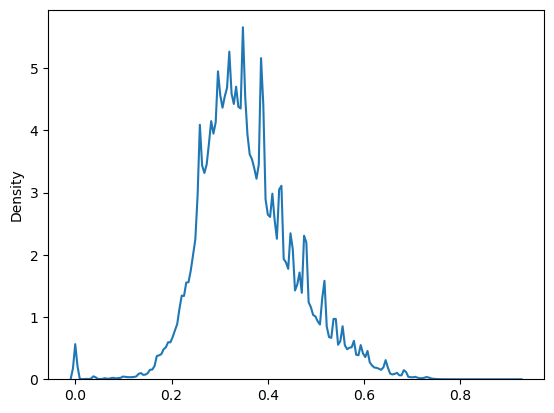

Сразу разделим датафрейм на трейн и тест во избежание утечек.

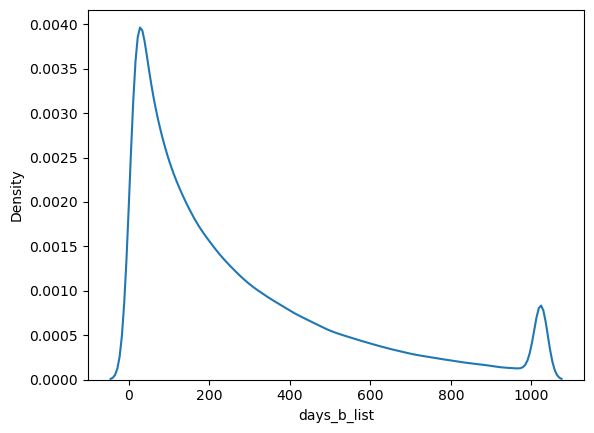

In [2]:
sns.kdeplot(df.days_b_list.map(lambda x: min(1024, len(x))));

In [3]:
cols2sort = [i for i in list(df.columns) if (i not in ["tr_order_list"]) and ("_list" in i)]
cols2sort

['mcc_cat_list',
 'days_b_list',
 'amnt_list',
 'op_kind_list',
 'card_type_list',
 'op_type_list',
 'payment_system_list',
 'income_list',
 'city_list']

~~Выделим Y.~~ (Уже сделано в спарке) Заметим, что в нем наблюдается очень сильный дисбаланс, как и в самом распределении mcc. 

In [4]:
df.last_mcc_category.value_counts()

last_mcc_category
2     350457
1     230786
3      78772
4      56547
8      47029
5      42866
6      35790
7      24654
11     17088
9      15890
12      9602
10      9109
13      7836
14      7313
15      5067
16      3619
18      3048
17      2849
19      2798
21      2793
20      2736
22      1901
23      1545
25      1295
24      1227
26       725
27       458
28        11
Name: count, dtype: int64

Отсюда, будет корректным использовать токенизаторы, учитывающие частоту встречаемости MCC. Т.к. мы имеем дело с цифрами, для быстроты и простоты возможно сконвертировать каждый код в букву и работать с токенизаторами "из коробки". 28 MCC удалим - слишком маленький саппорт.

In [ ]:
df = df.rename(columns={"last_mcc_category": "next_mcc"}) 
# df.to_parquet("task3_recsys/numeric_df_for_booster_feb7_v2.parquet") - same as orig, so no additional saving needed

In [5]:
num2letter_mapping = {k:v for k, v in zip(range(1, 29), ascii_letters[:26] + "12")}
df_v2 = df.copy()
df_v2.mcc_cat_list = df.mcc_cat_list.progress_apply(lambda x: ''.join(np.vectorize(num2letter_mapping.get)(x)).replace("2", ""))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 963811/963811 [00:49<00:00, 19598.28it/s]


In [11]:
df_v2.next_mcc = df_v2.next_mcc.apply(lambda x: num2letter_mapping[x])
df_v2 = df_v2[df_v2.next_mcc != "2"].sort_values(by="app_id").reset_index(drop=True).copy()

И разделим на трейн и тест - во избежание любого вида утечек.

In [ ]:
train_df, test_df = train_test_split(df_v2, test_size=.2, random_state=666, shuffle=True)
train_df.shape, test_df.shape

In [25]:
tokenizer = CharBPETokenizer(lowercase=True)
gc.collect()
tokenizer.train_from_iterator(train_df.sample(200_000).mcc_cat_list, vocab_size=256, min_frequency=2, show_progress=True)

tokenizer.save("task3_recsys/models/tokenizer/vocab_256_bpe.json") # используем

#

tokenizer = BertWordPieceTokenizer()
gc.collect()
tokenizer.train_from_iterator(train_df.sample(200_000).mcc_cat_list, vocab_size=256, min_frequency=2, show_progress=True)

tokenizer.save("task3_recsys/models/tokenizer/vocab_256_wp.json") # перформит похуже

Почти готово. но перед сохранением датасетов переведем `amount` в дискретный вид, используя квантили по трейну:

In [11]:
sample_arr = np.concatenate(train_df.sample(200_000).amnt_list.values)
sample_arr = sample_arr[np.nonzero(sample_arr)]
quantiles = np.quantile(sample_arr, np.arange(0, 1, .125))
{k:v for k, v in zip(quantiles, range(1, len(quantiles)+1))}

{0.0005583518068306148: 1,
 0.2589723765850067: 2,
 0.29354986548423767: 3,
 0.32024815678596497: 4,
 0.3482751250267029: 5,
 0.3785014748573303: 6,
 0.415071576833725: 7,
 0.4779440760612488: 8}

In [12]:
thr_mapping = {k:v for k, v in zip(quantiles, range(1, len(quantiles)+1))}
thrs = list(thr_mapping.keys())
train_df["amnt_list_discrete"] = train_df.amnt_list.progress_apply(lambda x: np.digitize(x, thrs))
test_df["amnt_list_discrete"] = test_df.amnt_list.progress_apply(lambda x: np.digitize(x, thrs))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 192760/192760 [00:01<00:00, 158237.18it/s]


Так выглядит итоговый DF для трансформера:

In [13]:
train_df[["app_id", "mcc_cat_list", "amnt_list_discrete", "next_mcc"]].head(5)

,app_id,mcc_cat_list,amnt_list_discrete,next_mcc
843045,878469,bbbbbbgbbeudnvbgfgffxxddvdffnaejjeajbgdjedqqal...,"[8, 8, 8, 8, 8, 8, 2, 8, 8, 7, 8, 6, 5, 8, 8, ...",a
644261,673064,bbbbbb,"[6, 6, 6, 5, 6, 6]",b
940297,978962,bbbbbbbadaadbeeaaabbbbbaeadaaabaavbbk,"[8, 7, 6, 6, 6, 7, 4, 7, 5, 7, 4, 6, 6, 6, 6, ...",h
570263,596073,bbbbbbbbggikieokfggaaaagaxfabafaaaabgggagbaaag...,"[7, 7, 7, 5, 6, 6, 7, 8, 7, 3, 6, 8, 7, 4, 6, ...",j
504312,528044,cbaabbbdcbcbibdccbcbbbbbsidgfccdbccbdgabbbdida...,"[5, 8, 7, 6, 4, 1, 7, 2, 2, 4, 6, 6, 7, 8, 5, ...",c


In [14]:
train_df[["app_id", "mcc_cat_list", "amnt_list_discrete", "next_mcc"]].reset_index(drop=True).to_parquet("task3_recsys/df_for_transformer_TRAIN.parquet")
test_df[["app_id", "mcc_cat_list", "amnt_list_discrete", "next_mcc"]].reset_index(drop=True).to_parquet("task3_recsys/df_for_transformer_TEST.parquet")

# END

---

Misc below (**ignore**):

Имеем некоторое кол-во мемберов с очень большой длиной - вместо базового слайса по последним N, где N - maxlen в будущем трансформере, разделим мемберов с длиной, например, в 2*N на два "подмембера" с длиной N. 



In [5]:
MAXLEN, LEN_THR = 256, 20

df["arr_len"] = df.tr_order_list.map(len)
df[df.arr_len > MAXLEN+LEN_THR].shape[0] / df.shape[0]

0.3587051818250674

In [17]:
df_sub = df[df.arr_len > MAXLEN+LEN_THR]

,app_id,mcc_cat_list,days_b_list,tr_order_list,amnt_list,arr_len
0,32,"[4, 2, 1, 4, 4, 4, 1, 4, 4, 1, 1, 4, 4, 4, 1, ...","[359, 359, 359, 358, 358, 358, 358, 357, 357, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.34429044, 0.42654428, 0.29469612, 0.2589723...",612
1,60,"[2, 16, 2, 1, 2, 2, 16, 2, 2, 2, 2, 2, 3, 15, ...","[359, 357, 353, 342, 342, 342, 340, 337, 335, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.42654428, 0.3475693, 0.38767713, 0.2796111,...",154
2,90,"[2, 2, 11, 3, 2, 3, 3, 2, 2, 2, 11, 5, 3, 2, 1...","[358, 356, 356, 354, 348, 347, 345, 344, 343, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.51683366, 0.55572605, 0.2975891, 0.44928715...",479
3,148,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[351, 351, 340, 337, 320, 320, 320, 316, 316, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.45630834, 0.38767713, 0.5846692, 0.34883797...",46
4,168,"[2, 1, 2, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 6, 1, ...","[355, 349, 342, 334, 326, 311, 304, 297, 282, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.3751697, 0.31337497, 0.46105185, 0.2640675,...",50
...,...,...,...,...,...,...
963806,1002758,"[1, 6, 7, 3, 1, 4, 2, 2, 6, 3, 1, 2, 2, 2, 1, ...","[359, 359, 358, 358, 358, 358, 357, 356, 355, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.27182618, 0.2917079, 0.23424111, 0.3231544,...",537
963807,1002883,"[8, 2, 1, 1, 7, 5, 5, 1, 2, 2, 2, 2, 2, 2, 2, ...","[159, 159, 159, 158, 158, 158, 158, 157, 152, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.46542543, 0.38767713, 0.33768436, 0.2451867...",81
963808,1002933,"[1, 4, 8, 2, 2, 2, 8, 2, 2, 8, 2, 1, 8, 1, 1, ...","[354, 352, 351, 340, 340, 323, 308, 291, 277, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.39370915, 0.30753997, 0.44928715, 0.4943640...",42
963809,1002962,"[11, 3, 1, 1, 5, 5, 6, 1, 1, 3, 16, 6, 3, 1, 6...","[355, 355, 355, 355, 355, 355, 355, 354, 354, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.29730922, 0.42466223, 0.33091226, 0.3137320...",465


In [22]:
sample_arr = np.concatenate(df.sample(100_000).amnt_list.values)
sample_arr = sample_arr[np.nonzero(sample_arr)]
quantiles = np.quantile(sample_arr, np.arange(0, 1, .125))

Переведем в дискретное распределение, опираясь на трешхолды по полученным квантилям:

In [25]:
{k:v for k, v in zip(quantiles, range(1, len(quantiles)+1))}

{0.0005583518068306148: 1,
 0.2589723765850067: 2,
 0.29383713006973267: 3,
 0.32024815678596497: 4,
 0.3486135005950928: 5,
 0.3787977397441864: 6,
 0.4157286286354065: 7,
 0.4779440760612488: 8}

In [33]:
thr_mapping = {k:v for k, v in zip(quantiles, range(1, len(quantiles)+1))}
thrs = list(thr_mapping.keys())
df["amnt_list_discrete"] = df.amnt_list.progress_apply(lambda x: np.digitize(x, thrs))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 963811/963811 [00:06<00:00, 153829.28it/s]


In [ ]:
sns.kdeplot(np.concatenate(df.amnt_list_discrete.values))

<AxesSubplot: ylabel='Density'>

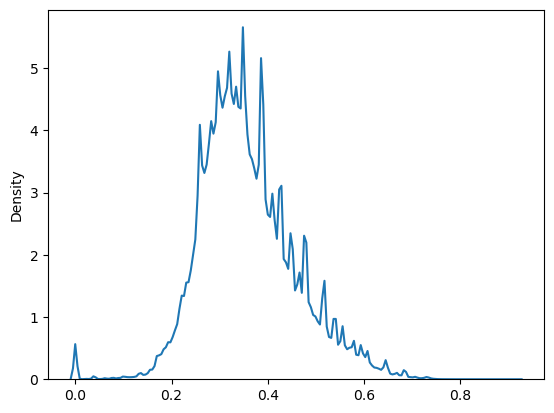

In [5]:
sns.kdeplot(np.concatenate(df.sample(100_000).amnt_list.values))

<AxesSubplot: ylabel='Density'>

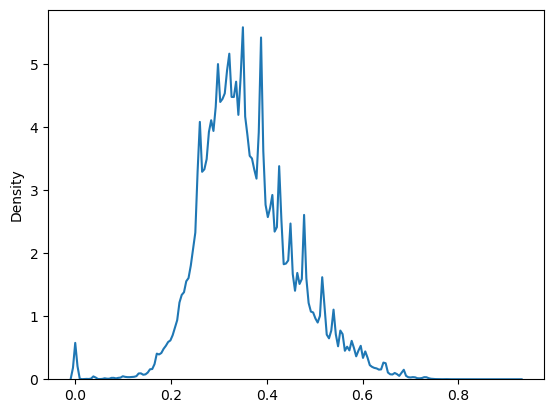

In [4]:
sns.kdeplot(np.concatenate(df.sample(100_000).amnt_list.values))

<AxesSubplot: ylabel='Density'>

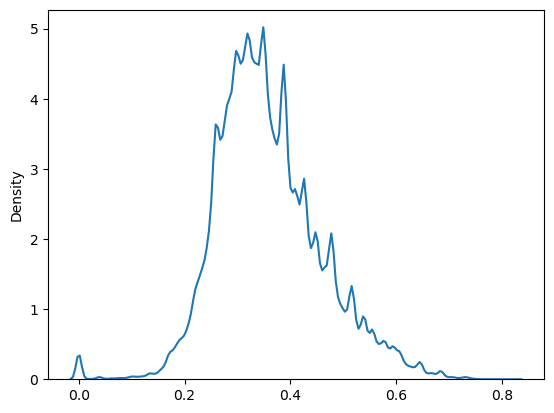

In [3]:
sns.kdeplot(np.concatenate(df.sample(100_000).amnt_list.values, dtype=np.float16))

In [16]:
df["isgood"] = df.progress_apply(lambda row: (row.tr_order_list == row.tr_order_list2).all(), axis=1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 963811/963811 [00:14<00:00, 68773.38it/s]


In [19]:
df[~df.isgood]

,app_id,mcc_cat_list,days_b_list,tr_order_list,amnt_list,tr_order_list2,isgood
25893,343682,"[18, 6, 1, 6, 1, 6, 11, 6, 11, 6, 11, 9, 21, 6...","[96, 359, 96, 359, 96, 359, 95, 359, 95, 359, ...","[565, 1, 566, 2, 567, 3, 568, 4, 569, 5, 570, ...","[0.5854493139665432, 0.6345674115275727, 0.484...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",False
29224,517465,"[5, 4, 10, 9, 1, 1, 1, 19, 2, 9, 2, 2, 2, 9, 9...","[358, 358, 358, 356, 355, 355, 355, 354, 288, ...","[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...","[0.3876771200456198, 0.3041673159273216, 0.392...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",False
64208,321970,"[1, 2, 2, 21, 5, 5, 9, 11, 9, 1, 10, 2, 2, 1, ...","[352, 359, 351, 359, 349, 357, 349, 356, 349, ...","[8, 1, 9, 2, 10, 3, 11, 4, 12, 5, 13, 6, 14, 7...","[0.2894946722589888, 0.5302446323884591, 0.477...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",False
64743,351107,"[2, 7, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[189, 153, 127, 115, 114, 113, 105, 98, 91, 91...","[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...","[0.5946198205801868, 0.646035618122452, 0.5168...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",False
74201,835448,"[4, 9, 1, 1, 6, 10, 6, 4, 6, 1, 16, 5, 4, 2, 4...","[220, 358, 220, 357, 219, 356, 219, 354, 219, ...","[229, 1, 230, 2, 231, 3, 232, 4, 233, 5, 234, ...","[0.3911020814225655, 0.4914862395697451, 0.449...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",False
...,...,...,...,...,...,...,...
929840,240623,"[11, 2, 2, 2, 2, 2, 2, 2, 11, 11, 11, 2, 2, 2,...","[259, 357, 257, 357, 253, 354, 248, 349, 245, ...","[49, 1, 50, 2, 51, 3, 52, 4, 53, 5, 54, 6, 55,...","[0.3876771200456198, 0.4654254330729043, 0.516...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",False
931081,307012,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[322, 294, 264, 233, 201, 170, 162, 162, 152, ...","[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...","[0.5168336566977262, 0.45793447044972274, 0.51...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",False
939834,764761,"[1, 13, 1, 1, 1, 1, 3, 1, 1, 1, 7, 1, 3, 1, 3,...","[101, 359, 101, 359, 101, 359, 100, 357, 99, 3...","[270, 1, 271, 2, 272, 3, 273, 4, 274, 5, 275, ...","[0.253060185981737, 0.3183020909751167, 0.3415...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",False
959555,788513,"[1, 4, 2, 3, 1, 4, 2, 1, 1, 14, 2, 1, 1, 2, 2,...","[352, 352, 352, 352, 351, 351, 351, 351, 350, ...","[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...","[0.29007537064421424, 0.29842041136607067, 0.4...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",False
